In [1]:
completePath = "data/energydata_complete.csv"
trainingPath = "data/training.csv"
testingPath = "data/testing.csv"

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [3]:
df = pd.read_csv(completePath)

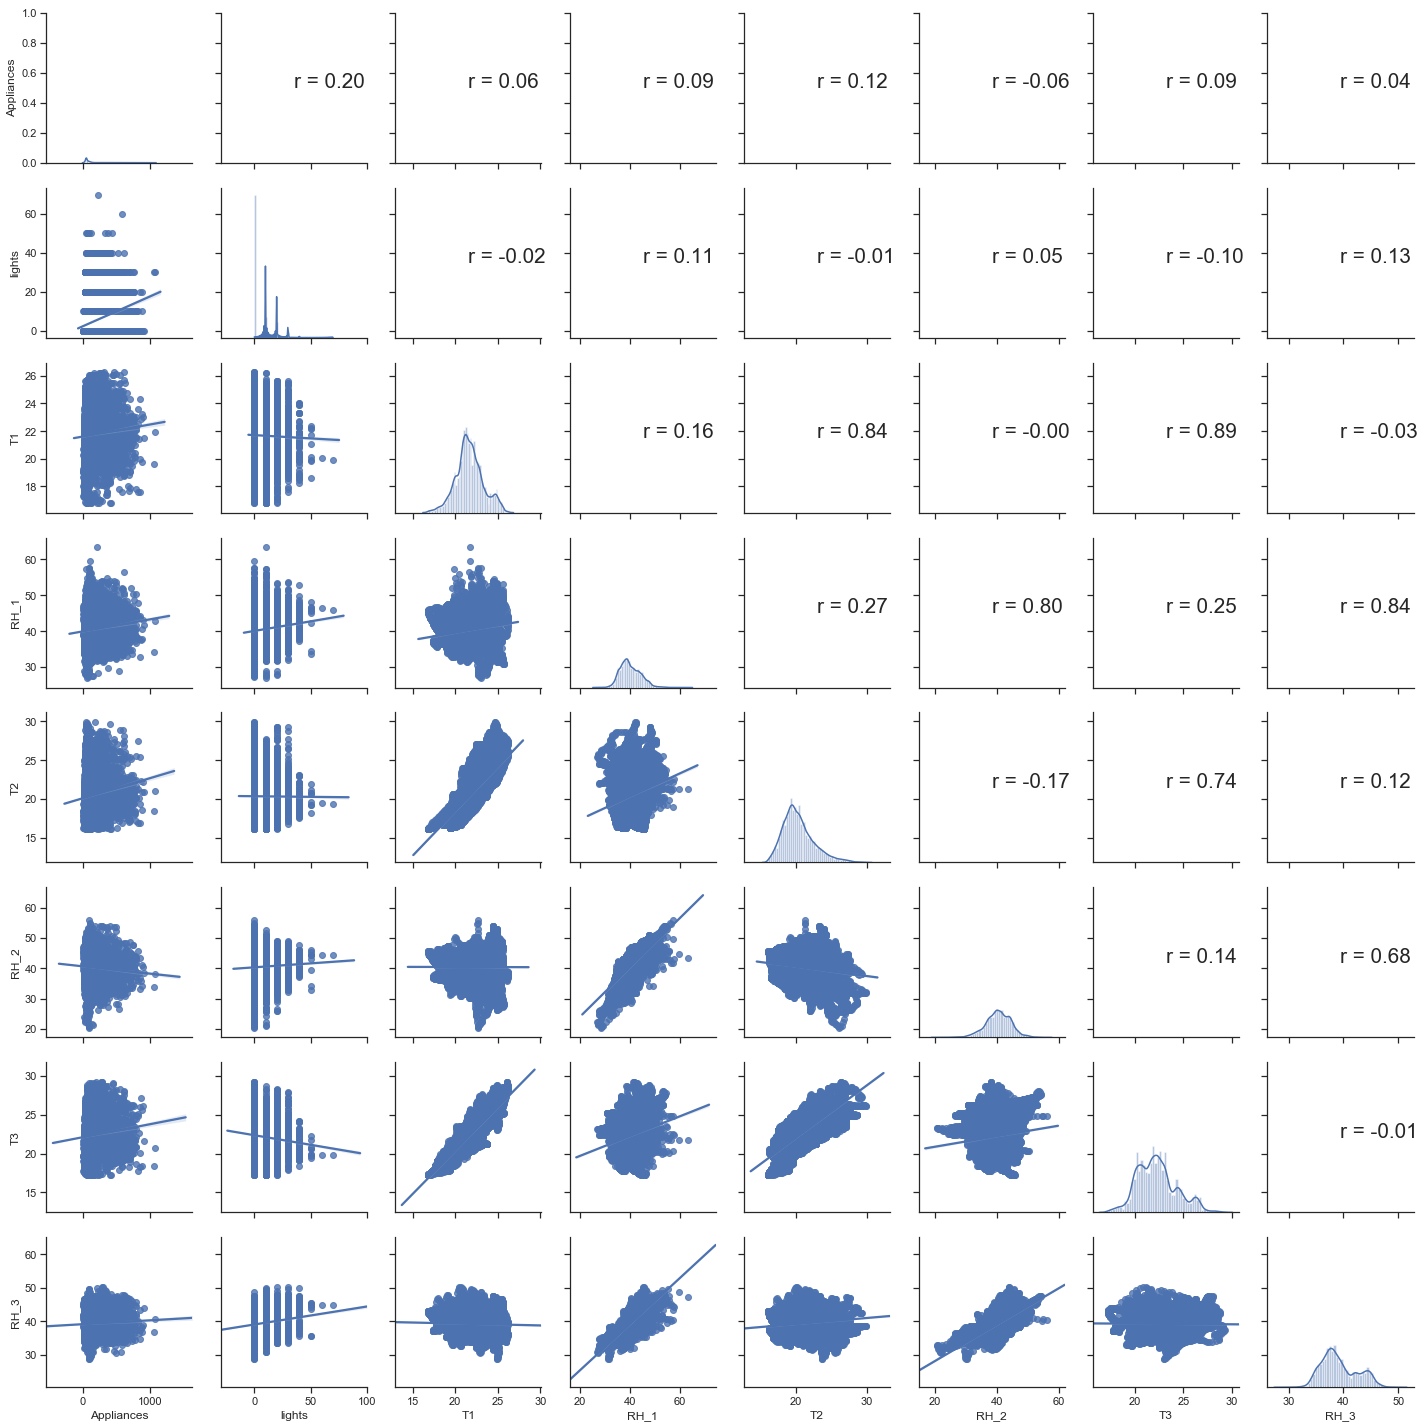

In [15]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.3, .5), xycoords=ax.transAxes,size="xx-large")

sns.set(style="ticks", color_codes=True)
pairp = sns.PairGrid(df,vars=['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3','RH_3'])
pairp.map_diag(sns.distplot)
pairp.map_lower(sns.regplot)
pairp.map_upper(corrfunc)

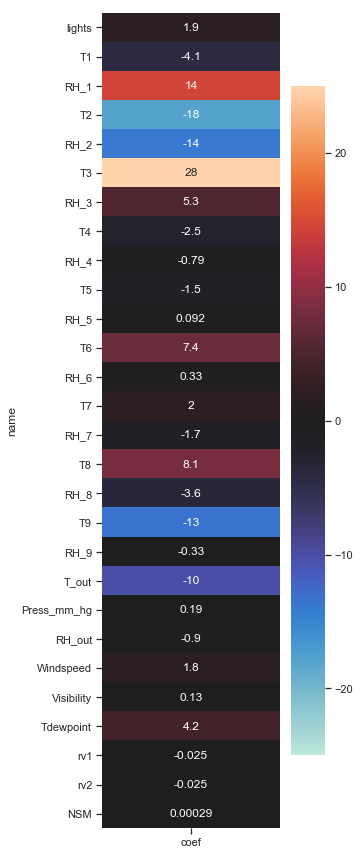

In [171]:
predictors = df_train.drop('Appliances', axis=1)._get_numeric_data()
linRegression = LinearRegression(normalize=True)
linRegression = linRegression.fit(predictors,df_train['Appliances'])
coefs = pd.DataFrame({'coef':linRegression.coef_,"name":predictors.columns.values}).set_index('name')

fig, ax = plt.subplots(figsize=(4,15))
sns.heatmap(coefs,annot=True, center=0,vmin=-25,vmax=25,ax=ax)
None


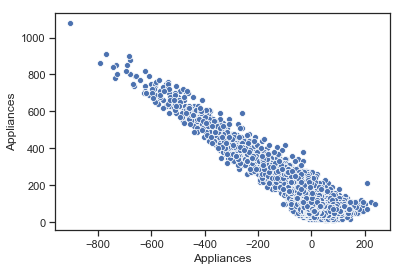

In [180]:
yHat = linRegression.predict(predictors)
y = df_train['Appliances']
residuals = yHat - y

sns.scatterplot(residuals,y)

## Pairs plot reproduction

Here i have tried to recreate the exact plot from the paper with some custom code, all the plots and correlation coefficients look the same

In [81]:
df_train = pd.read_csv(trainingPath)
estimator = LinearRegression(normalize=True)
selector = RFE(estimator)
selector = selector.fit(predictors,df_train['Appliances'])
df_masked = df_train[predictors.columns[selector.support_]]

In [107]:
rankings = pd.DataFrame({'name':predictors.columns,'rank':selector.ranking_,'support':selector.support_}).set_index('name').sort_values('rank')
rankings

,rank,support
name,,
lights,1,True
T1,1,True
RH_1,1,True
T2,1,True
RH_2,1,True
T3,1,True
RH_3,1,True
T4,1,True
Windspeed,1,True


In [121]:
print(f"Total predictors:   {len(df_train.columns.values)}")
print(f"Numeric predictors: {len(predictors.columns.values)}")
print(f"Reduced amount:     {len(df_masked.columns.values)}")

Total predictors:   32
Numeric predictors: 28
Reduced amount:     14


## RFE reproduction

above is the reproduction of using recursive feature eliminations with SKLearn, i opted to normalize the data, it resulted in 14 of the 28 numeric variables being kept, this varies from the paper as it started with 35 variables and reduced them down to 35

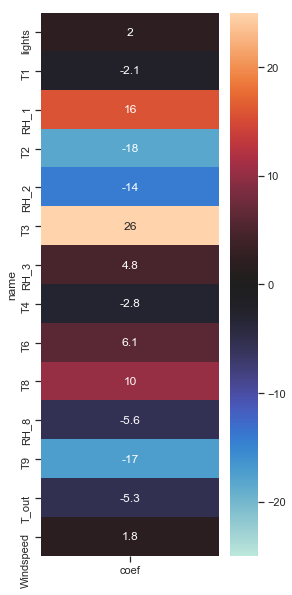

In [170]:
predictors = df_masked
linRegression = LinearRegression(normalize=True)
linRegression = linRegression.fit(predictors,df_train['Appliances'])
coefs = pd.DataFrame({'coef':linRegression.coef_,"name":predictors.columns.values}).set_index('name')

fig, ax = plt.subplots(figsize=(4,10))
sns.heatmap(coefs,annot=True, center=0,vmin=-25,vmax=25,ax=ax)
None

## Post reduction correlation

above is the coeficents maped to colors where light blue is strong negative and light red is strong positive correlation. here we can see much more of our coeffiecnts (witch we normalize earlier meaning we can compare them) are much stronger as we threw away a large amount of the weaker ones

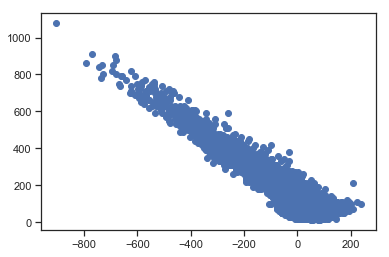

In [179]:
yHat = linRegression.predict(predictors)
y = df_train['Appliances']
residuals = yHat - y

sns.scatterplot(residuals,y)